In [1]:
from gensim.models import Word2Vec

In [7]:
import pandas as pd
import numpy as np
import networkx as nx
import pickle

from tqdm import tqdm
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
%matplotlib inline


In [8]:
import pickle
# Load the list of graphs
with open("data/disease_graphs.pkl", "rb") as f:
    loaded_graphs = pickle.load(f)

In [9]:
G=loaded_graphs[38]
# Graph metrics
print("Total nodes:", G.number_of_nodes())
print("Total edges:", G.number_of_edges())

components = list(nx.connected_components(G))
print("Connected components:", len(components))
print("Largest component size:", len(max(components, key=len)))

avg_deg = sum(dict(G.degree()).values()) / G.number_of_nodes()
print("Average degree:", round(avg_deg, 2))
print("Density:", round(nx.density(G), 4))
print("\nTop 10 high-degree nodes:")


top_nodes = sorted(loaded_graphs[38].degree(), key=lambda x: x[1], reverse=True)[:10]
for node, degree in top_nodes:
    print(f"{node}: {degree}")

Total nodes: 15875
Total edges: 229721
Connected components: 125
Largest component size: 15558
Average degree: 28.94
Density: 0.0018

Top 10 high-degree nodes:
ENSG00000141510: 757
ENSG00000143947: 579
ENSG00000221983: 511
ENSG00000146648: 493
ENSG00000168036: 458
ENSG00000274618: 446
ENSG00000183598: 444
ENSG00000075624: 433
ENSG00000142208: 428
ENSG00000149806: 412


In [11]:
# check the basic properties of th
G.nodes

NodeView(('ENSG00000004059', 'ENSG00000072818', 'ENSG00000122218', 'ENSG00000275338', 'ENSG00000184432', 'ENSG00000105669', 'ENSG00000134287', 'ENSG00000101199', 'ENSG00000156675', 'ENSG00000108669', 'ENSG00000144711', 'ENSG00000103769', 'ENSG00000149182', 'ENSG00000129083', 'ENSG00000168374', 'ENSG00000153317', 'ENSG00000131242', 'ENSG00000120370', 'ENSG00000114331', 'ENSG00000242247', 'ENSG00000164144', 'ENSG00000147889', 'ENSG00000107862', 'ENSG00000132254', 'ENSG00000157985', 'ENSG00000151693', 'ENSG00000111481', 'ENSG00000003056', 'ENSG00000125447', 'ENSG00000151532', 'ENSG00000292253', 'ENSG00000103365', 'ENSG00000100083', 'ENSG00000197081', 'ENSG00000105355', 'ENSG00000004478', 'ENSG00000168439', 'ENSG00000151623', 'ENSG00000096060', 'ENSG00000197632', 'ENSG00000109971', 'ENSG00000174842', 'ENSG00000185122', 'ENSG00000126803', 'ENSG00000198793', 'ENSG00000142208', 'ENSG00000110958', 'ENSG00000132002', 'ENSG00000171497', 'ENSG00000096384', 'ENSG00000170606', 'ENSG00000106993', 'E

# Deep Walk Basics

Random Walk

In [16]:
import random
# function to generate random walk sequences of nodes for a particular node
def get_random_walk(node, walk_length):
    # initialization
    random_walk_length = [node]
    
    #loop over to get the nodes visited in a random walk
    for i in range(walk_length-1):
        # list of neighbors
        neighbors = list(G.neighbors(node))
        # if the same neighbors are present in ranom_walk_length list, then donot add them as new neighbors
        neighbors = list(set(neighbors) - set(random_walk_length))    
        if len(neighbors) == 0:
            break
        # pick any one neighbor randomly from the neighbors list
        random_neighbor = random.choice(neighbors)
        # append that random_neighbor to the random_walk_length list
        random_walk_length.append(random_neighbor)
        node = random_neighbor
        
    return random_walk_length

In [17]:
# check random walk for node 'ENSG00000141510'
get_random_walk('ENSG00000141510', 10)

['ENSG00000141510',
 'ENSG00000139842',
 'ENSG00000113851',
 'ENSG00000100387',
 'ENSG00000062725',
 'ENSG00000145780',
 'ENSG00000005981',
 'ENSG00000160445',
 'ENSG00000124702',
 'ENSG00000128607']

For every node we can generate multiple random walks

In [18]:
# calculate random walks for every node in the Graph
all_nodes = list(G.nodes())
number_of_random_walks = 5
random_walks = []

for node in tqdm(all_nodes):
    # number of random walks
    for i in range(number_of_random_walks):
        # append the random walk sequence of a node from a specified length
        random_walks.append(get_random_walk(node, 10))

100%|██████████| 15875/15875 [00:17<00:00, 918.90it/s] 


In [20]:
len(random_walks)

79375

In [21]:
random_walks[0]

['ENSG00000004059',
 'ENSG00000072818',
 'ENSG00000111737',
 'ENSG00000213047',
 'ENSG00000143355',
 'ENSG00000130511',
 'ENSG00000121454',
 'ENSG00000123576',
 'ENSG00000107187',
 'ENSG00000182253']

In [22]:
random_walks[1]

['ENSG00000004059',
 'ENSG00000103769',
 'ENSG00000075785',
 'ENSG00000104946',
 'ENSG00000170296',
 'ENSG00000130479',
 'ENSG00000177169',
 'ENSG00000110046',
 'ENSG00000057663',
 'ENSG00000142208']

Use word2vec to train learn node embeddings

In [23]:
# train word2vec model
model = Word2Vec(window = 4, sg = 1, hs = 0,
                 negative = 10, # for negative sampling
                 alpha=0.03, min_alpha=0.0007,
    )

model.build_vocab(random_walks, progress_per=2)

In [24]:
model.train(random_walks, total_examples = model.corpus_count, epochs=20, report_delay=1)

(15224260, 15224260)

In [25]:
print(model)

Word2Vec<vocab=15875, vector_size=100, alpha=0.03>


In [ ]:
# most similar nodes to node 'ENSG00000141510' center node
for node, _ in model.wv.most_similar('ENSG00000141510'):
    print((node, _))

('ENSG00000197050', 0.5361069440841675)
('ENSG00000120471', 0.5284470915794373)
('ENSG00000172667', 0.4878539741039276)
('ENSG00000102760', 0.4824971854686737)
('ENSG00000101166', 0.48084813356399536)
('ENSG00000103657', 0.4804541766643524)
('ENSG00000106346', 0.44129788875579834)
('ENSG00000136048', 0.4406191408634186)
('ENSG00000179361', 0.43732354044914246)
('ENSG00000170855', 0.43718722462654114)


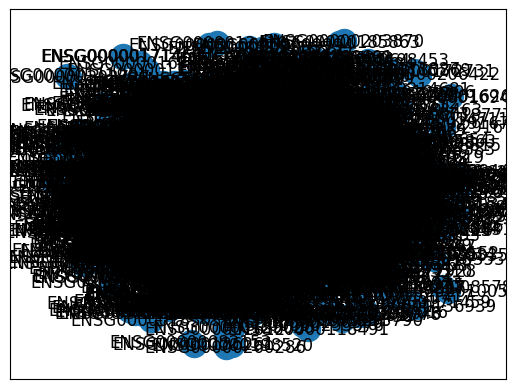

In [28]:
nx.draw_networkx(G)

In [36]:
def plot_nodes(word_list):
    X = model.wv[word_list]
    
    # reduce dimensions to 2
    pca = PCA(n_components=2)
    result = pca.fit_transform(X)
    
    
    plt.figure(figsize=(12,9))
    # create a scatter plot of the projection
    plt.scatter(result[:, 0], result[:, 1])
    for i, word in enumerate(word_list):
        plt.annotate(".", xy=(result[i, 0], result[i, 1]))
        
    plt.show()

In [37]:
numbers = list(G.nodes)

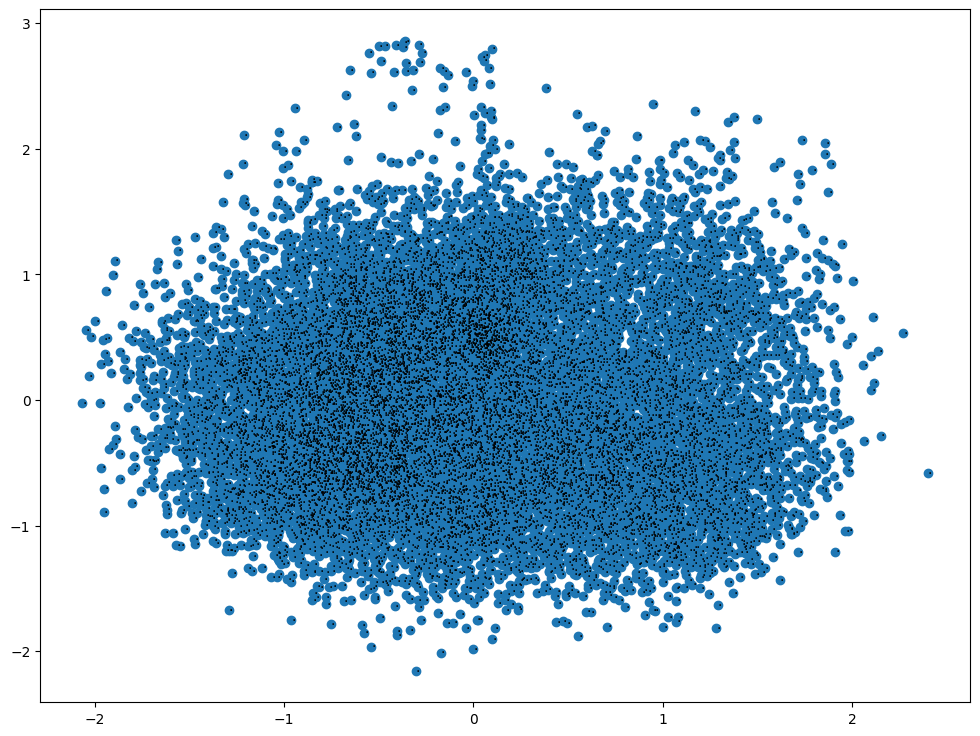

In [38]:
plot_nodes(numbers)